In [ ]:
import json
import torch, re, os, cv2
from collections import defaultdict
from cv2.typing import MatLike
import matplotlib.pyplot as plt
import numpy as np

def load_camera_matrices(path, matrix_types=None):
    """
    Loads camera matrices from .npy files in the specified directory.

    Parameters:
        path (str): Path to the directory containing camera matrix files.
        matrix_types (set or list, optional): Specifies which matrix types to load (e.g., {'K', 'RT'}).
        If None, all available matrices ('K', 'RT', 'P') will be loaded.

    Returns:
        dict: A dictionary mapping camera numbers to their respective matrices.
    """
    cameras = defaultdict(dict)
    file_pattern = re.compile(r"^Camera_(\d+)_(K|RT|P)\.npy$")
    
    if matrix_types is not None:
        matrix_types = set(matrix_types)  # Ensure it's a set for quick lookup
    
    for filename in sorted(os.listdir(path)):  # Sort filenames alphabetically
        match = file_pattern.match(filename)
        if match:
            cam_number, matrix_type = match.groups()
            cam_number = int(cam_number)  # Convert camera number to integer
            if matrix_types is None or matrix_type in matrix_types:
                filepath = os.path.join(path, filename)
                cameras[cam_number][matrix_type] = torch.tensor(np.load(filepath))
    
    return cameras

def load_renders(renders_path):
    renders = defaultdict(dict)
    pattern = re.compile(r"([a-zA-Z]+)(\d+)\.png")
    for filename in sorted(os.listdir(renders_path), key=lambda x: (re.match(pattern, x).group(1), int(re.match(pattern, x).group(2))) if re.match(pattern, x) else (x, float('inf'))):
        match = pattern.match(filename)
        if match:
            word, number = match.groups()
            number = int(number)  # Convert number to integer for sorting

            image_path = os.path.join(renders_path, filename)
            image = cv2.imread(image_path)  # Load image using OpenCV
            if image is not None:
                renders[word][number] = image  # Store image in the nested dictionary

    return renders

def get_projmats_and_edgemap_info(view_idx, target_mesh: str, matrices, edgemaps, edgemaps_len):
    """
    Retrieves the projection matrices and target edgemap information for the specified view indices and target mesh.

    Parameters:
        view_idx (list): List of indices for which to retrieve projection matrices and edgemaps.
        target_mesh (str): The target mesh name (e.g., 'balloon') to extract edgemaps and lengths for.
        matrices (dict): Dictionary containing camera matrices.
        edgemaps (dict): Dictionary containing edgemaps for various meshes.
        edgemaps_len (dict): Dictionary containing the lengths of the edgemaps for each mesh.

    Returns:
        tuple: A tuple containing the projection matrices (torch.Tensor) and the target edgemap information (tuple of torch.Tensors).
    """
    # Get the projection matrices for the specified view indices
    projmats = torch.stack([matrices[view_idx[i]]["P"] for i in range(len(view_idx))])

    # Get the target edgemaps for the specified target mesh
    tgt_edgemaps = torch.nn.utils.rnn.pad_sequence([edgemaps[target_mesh][i] for i in view_idx], batch_first=True, padding_value=0.0)
    tgt_edgemaps_len = torch.tensor([edgemaps_len[target_mesh][i] for i in view_idx])

    # Pack the target edgemaps and their lengths
    tgt_edgemap_info = (tgt_edgemaps, tgt_edgemaps_len)

    return projmats, tgt_edgemap_info

def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map


def visualize_edges(renders, edgemap_options, target_mesh):
    num_views = 12  # assuming 12 views per mesh
    rows, cols = 6, 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

    mesh_renders = renders.get(target_mesh, {})
    mesh_options = edgemap_options.get(target_mesh, {})

    for view_idx in range(num_views):
        row, col = divmod(view_idx, cols)
        ax = axes[row, col]

        img = mesh_renders.get(view_idx)
        if img is not None and str(view_idx) in mesh_options:
            edge_option = mesh_options[str(view_idx)]
            edges = canny_edge_map(img, edge_option)
            ax.imshow(edges, cmap='gray')
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)

        ax.set_title(f"View {view_idx}")
        ax.axis('off')

    plt.suptitle(f"Canny edges for mesh: {target_mesh}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Load configuration from JSON file
with open("/Users/jeffreyliang/Documents/Honours/honours/src/experiments/skyconfig_local.json", "r") as f:
    cfg = json.load(f)

mesh_dir = cfg["paths"]["mesh_dir"]
mesh_res = cfg["paths"]["mesh_res"]
renders_path = cfg["paths"]["renders_path"]
matrices_path = cfg["paths"]["matrices_path"]

# Fix edgemap_options to be a dictionary where keys are mesh names and values are dictionaries of view indices
edgemap_options = {mesh["name"]: {str(k): v for k, v in mesh["edgemap_options"].items()} for mesh in cfg["meshes"]}

# Load renders and camera matrices
renders = load_renders(renders_path)
matrices = load_camera_matrices(matrices_path)


In [ ]:
visualize_edges(renders, edgemap_options, target_mesh="balloon")

In [104]:
import json
import torch, re, os, cv2
from collections import defaultdict
from cv2.typing import MatLike
import matplotlib.pyplot as plt
import numpy as np

def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img_greyscale = cv2.GaussianBlur(img_greyscale, (3,3), 1)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

import os
import cv2
import re
from collections import defaultdict

def load_renders_for_material(renders_path, material, object_name):
    """
    Loads renders for a specific object and material by navigating the material folder.
    
    Parameters:
        renders_path (str): Path to the directory containing the render images.
        material (str): Material name to filter the renders (e.g., "Diffuse").
        object_name (str): The object name (e.g., "Oblique6") to filter the renders.
    
    Returns:
        dict: A dictionary mapping view names ("Above_3", "Ground_1", etc.) to their corresponding images.
    """
    renders = defaultdict(list)
    material_path = os.path.join(renders_path, material)  # Construct path for the material folder
    
    if not os.path.exists(material_path):
        print(f"Material folder {material_path} not found!")
        return renders

    # Regex pattern: Extract Object<number> and View_<number>, ignoring _Cam_.
    # Example: Oblique6_Cam_Above_3.png -> object_name: Oblique6, view_name: Above_3
    pattern = re.compile(rf"^({object_name})_Cam_(Overhead|Above|Ground)_(\d+)\.png")

    for filename in sorted(os.listdir(material_path)):
        match = pattern.match(filename)
        if match:
            obj, view_type, view_number = match.groups()
            if obj == object_name:
                # Construct the view name as "Above_3", "Ground_1", etc.
                full_view_name = f"{view_type}_{view_number}"
                image_path = os.path.join(material_path, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    renders[full_view_name] = image  # Store images under view name

    return renders


def apply_canny_to_renders_for_material(renders, edgemap_options, object_name, material):
    """
    Applies Canny edge detection to renders for a specific object and material using the provided edgemap_options.

    Parameters:
        renders (dict): Dictionary containing render images.
        edgemap_options (dict): Dictionary containing edge map options.
        object_name (str): The object name (e.g., 'Oblique1').
        material (str): The material name (e.g., 'Diffuse').

    Returns:
        dict: A dictionary mapping view indices to their corresponding Canny edge map results.
    """
    edge_maps = {}

    for view_name, options in edgemap_options.get(object_name, {}).items():
        # Get the edge map for this specific view name
        edge_map = renders.get(view_name)  # Get the image by the full view name (e.g., "Overhead_1")
        
        if edge_map is not None:
            # Apply Canny edge map with the options
            edge_maps[view_name] = canny_edge_map(edge_map, options)

    return edge_maps

def plot_edge_maps(edge_maps):
    """
    Plots the edge maps in a grid with minimal white space and titles indicating the view names.

    Parameters:
        edge_maps (dict): A dictionary mapping view names to their corresponding edge map results.
    """
    # Calculate number of rows and columns based on the number of edge maps
    num_views = len(edge_maps)
    rows = (num_views + 1) // 2  # N rows, 2 columns
    cols = 2
    
    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, (view_name, edge_map) in enumerate(edge_maps.items()):
        ax = axes[idx]
        ax.imshow(edge_map, cmap='gray')
        ax.set_title(view_name)  # Title with the view name (e.g., "Overhead_1")
        ax.axis('off')  # Remove axis labels and ticks
    
    # Turn off any unused axes
    for ax in axes[num_views:]:
        ax.axis('off')

    plt.tight_layout(pad=1.0)  # Minimal white space
    plt.show()

# Example usage:
# Assuming `edge_maps` is the dictionary containing the edge maps (e.g., {"Overhead_1": edge_map1, "Above_1": edge_map2, ...})


renders_path = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/renders"
material = "NoGround"  # Example material
object_name = "Oblique13"  # Example object name
renders = load_renders_for_material(renders_path, material, object_name)
print([k for k in renders.keys()])


['Above_0', 'Above_1', 'Above_2', 'Above_3', 'Above_4', 'Above_5', 'Above_6', 'Ground_0', 'Ground_1', 'Ground_2', 'Ground_3', 'Ground_4', 'Overhead_0']


13


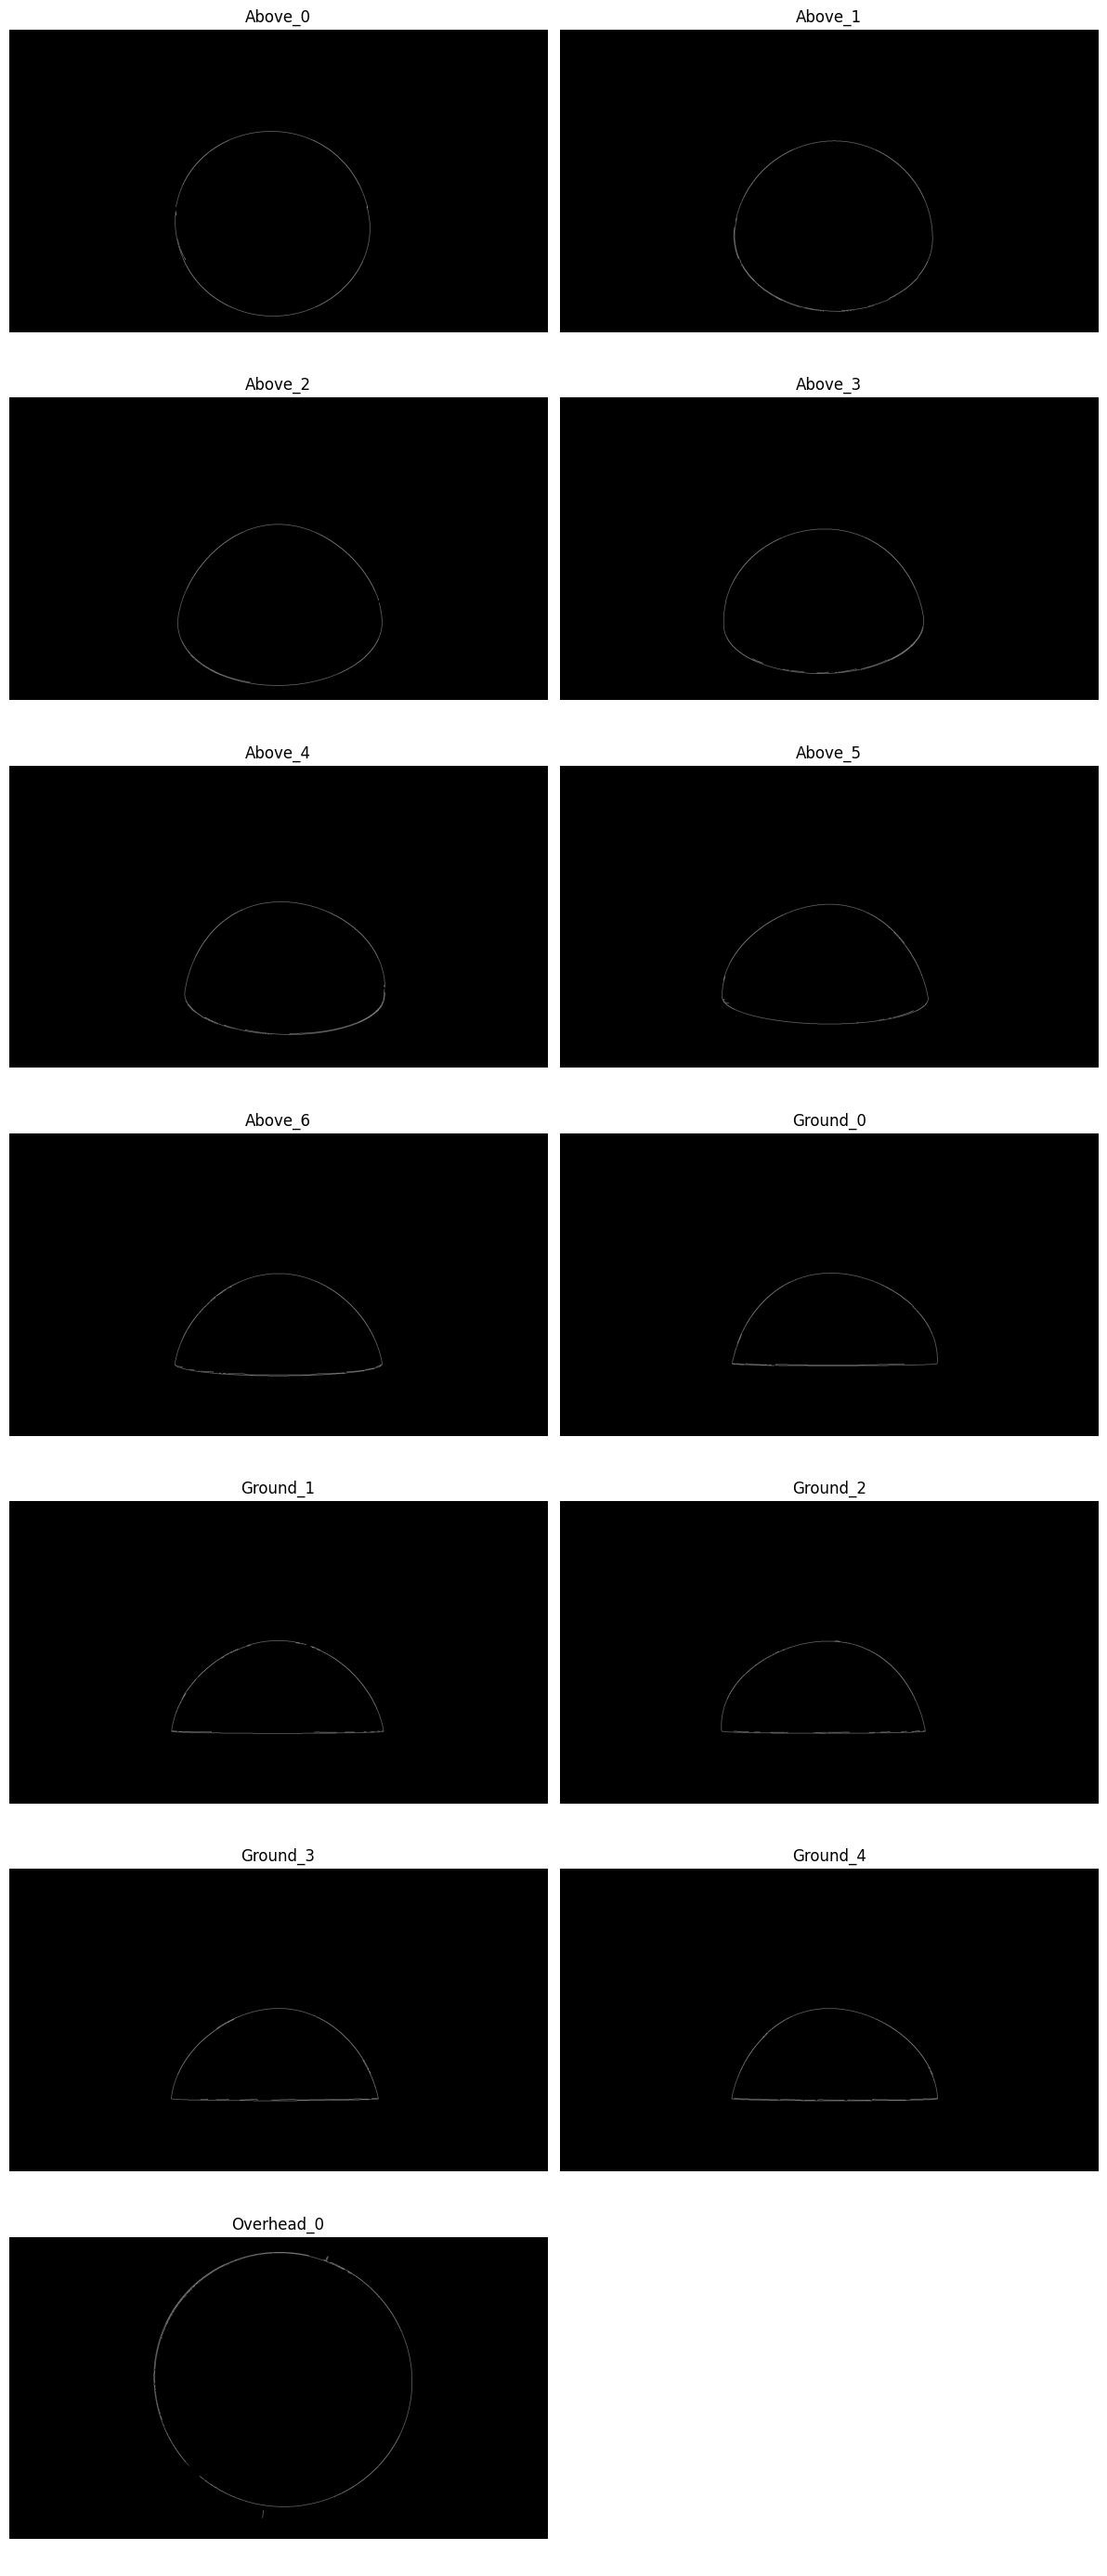

In [106]:
# Define edge map options using dictionary comprehension
edgemap_options = {
    object_name: {
        "Above_0":      (False, 10, 45),
        "Above_1":      (False, 10, 45),
        "Above_2":      (False, 10, 45),
        "Above_3":      (False, 10, 45),
        "Above_4":      (False, 10, 45),
        "Above_5":      (False, 10, 45),
        "Above_6":      (False, 10, 45),    
        "Ground_0":     (False, 10, 25),
        "Ground_1":     (False, 10, 30),
        "Ground_2":     (False, 10, 30),
        "Ground_3":     (False, 10, 45),
        "Ground_4":     (False, 10, 45),
        "Overhead_0":   (False, 10, 35), # (hist_eq=True, low_thresh=15, high_thresh=250)
    }
}

# edgemap_options = defaultdict(lambda: (False, 15, 200))  # Default option: (False, 0, 0) for equalisation, low, high thresholds

# Apply Canny edge detection to the filtered renders based on material and object
edge_maps = apply_canny_to_renders_for_material(renders, edgemap_options, object_name, material)
print(len(edge_maps))

plot_edge_maps(edge_maps)


In [107]:
edgemap_options = {
    "Overhead_0": (True, 15, 250),  # (hist_eq=True, low_thresh=15, high_thresh=250)

    "Above_0": (True, 25, 250),
    "Above_1": (True, 25, 250),
    "Above_2": (False, 15, 200),
    "Above_3": (True, 20, 240),
    "Above_4": (True, 25, 250),
    "Above_5": (True, 25, 250),
    "Above_6": (True, 25, 250),

    "Ground_0": (False, 10, 150),
    "Ground_1": (False, 10, 150),
    "Ground_2": (True, 18, 210),
    "Ground_3": (True, 12, 180),
    "Ground_4": (False, 10, 150),

}


In [ ]:
object_names = [f"Icosphere{i}" for i in range(9)]
material = ""  # Set your actual material name here
view_name = "Ground_0"
renders_path = "/Users/jeffreyliang/Documents/Honours/Blender/translation/renders"

# Set common Canny parameters
canny_params = (False, 15, 100)

all_edge_maps = {}

for obj in object_names:
    renders = load_renders_for_material(renders_path, material, obj)
    if view_name in renders:
        img = renders[view_name]
        edge_map = canny_edge_map(img, canny_params)
        all_edge_maps[obj] = edge_map
    else:
        print(f"{view_name} not found for {obj}")

# Plot all objects' Ground_0 edge maps
def plot_objects_edge_maps(edge_maps):
    num_objects = len(edge_maps)
    cols = 3
    rows = (num_objects + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 5))
    axes = axes.flatten()
    
    for idx, (obj_name, edge_map) in enumerate(edge_maps.items()):
        axes[idx].imshow(edge_map, cmap='gray')
        axes[idx].set_title(obj_name)
        axes[idx].axis('off')
    
    for ax in axes[num_objects:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_objects_edge_maps(all_edge_maps)
